### Generate unimodular matrix

In [1]:
# nbc is number of unimodular matrixes multiplied together. Recommended to use 2n
def generate_unimodular_matrix(n, nbc = 1):

    # Start with identity
    U = matrix.identity(n)
    dist = GeneralDiscreteDistribution([1/7, 5/7, 1/7])

    for _ in range(nbc):
        U1 = matrix.identity(n)
        index = randint(0,n-1)
    
        if randint(0,1):
            U1[index] = [dist.get_random_element() - 1 for _ in range(n)]
            U1[index, index] = 1
        else:
            for j in range(n):
                U1[j, index] = dist.get_random_element() - 1
            U1[index,index] = 1
        U *= U1
        
    return U
print("done")

done


In [2]:
def calculate_orthogonality_defect_ROWS(M):
    """
    Calculates the Orthogonality Defect (Hadamard Ratio) of a basis matrix M.
    Assumes basis vectors are the ROWS of M.
    """
    precision=100
    RR_prec = RealField(precision)
    
    n = M.nrows()
    if n == 0:
        return RR_prec(1)  # Defect of empty basis is 1
    
    # 1. Get the determinant as an exact INTEGER first
    int_det = M.det()
    if int_det == 0:
        return RR_prec(0)
        
    # 2. Calculate log(|det(M)|) using high precision
    # We convert the (potentially huge) integer to the high-precision field
    log_det = log(RR_prec(abs(int_det)))
    
    # 3. Calculate sum(log(||row_i||))
    sum_log_norms = RR_prec(0)
    M_RR = M.change_ring(RR_prec) # Use high-precision matrix
    
    for i in range(n):
        row_norm = M_RR.row(i).norm()
        
        if row_norm == 0:
            return RR_prec(0) # Basis is degenerate
            
        sum_log_norms += log(row_norm)
        
    # 4. log(Defect) = log_det - sum_log_norms
    log_defect = log_det - sum_log_norms
    
    # 5. Defect = exp(log_Defect)
    # This will now be a correct number between 0 and 1
    return exp(log_defect)

print("done")

done


### Key Generation Function

In [106]:
# l is Amplitude of coefficients in private key
def generate_ggh_keys(n, l = 4, nbc=1):

    # k value as suggested in slides
    k = ceil(sqrt(n)) * l
    # k = n * l + 1
    ID_k = k * matrix.identity(n)

    # private_key = I*k + R where R ∈ [-l, .... , l]
    private_key = ID_k + MatrixSpace(ZZ, n,n).random_element(x=-l, y=l+1, distribution='uniform')
    while private_key.det() == 0:
        private_key = ID_k + MatrixSpace(ZZ, n,n).random_element(x=-l, y=l+1, distribution='uniform')
    
    # LLL is reducing the matrix 
    private_key = private_key.LLL()

    defect = calculate_orthogonality_defect_ROWS(private_key)
    print(f"Defect of basis: {defect:.6f}\n")

    U = generate_unimodular_matrix(n, nbc)

    public_key = U * private_key
    
    return private_key, public_key, U

print("done")

done


### Encryption Function

In [4]:
def ggh_encrypt(public_key, message, maxIterations=128):

    n = public_key.nrows()
    r = round(min([public_key.column(i).norm(2) for i in range(n)]) / 6)
    err = vector(ZZ, [randint(-1,1) for _ in range(n)])
    counter = 0
    while err.norm(2) >= r:
        err = vector(ZZ, [randint(-1,1) for _ in range(n)])
        if(counter > maxIterations):
            err = vector(ZZ, [randint(0,1) if (i<r) else 0 for i in range(n)])
            break
    return message*public_key + err

print("done")

done


### Decryption Function

In [5]:
# Cell 7: Decryption function
def ggh_decrypt(private_key, U, ciphertext):

    m1 = ciphertext * private_key.inverse()
    m2 = m1.apply_map(lambda x: round(x))

    return m2 * U.inverse()

print("done")

done


# Encryption/Decryption Testing

In [6]:
def test(n, num_tests, nbc):

    good = 0
    ERR = []
    bad = 0

    for i in range(num_tests):
        private_key, public_key, U = generate_ggh_keys(n, nbc)
        message = vector(ZZ, [randint(0,1) for _ in range(n)])
        ciphertext = ggh_encrypt(public_key, message)

        plaintext = ggh_decrypt(private_key, U, ciphertext)

        if plaintext == message:
            good += 1
        else:
            bad += 1
            e = message - plaintext
            print(f"Error Detected: {e}")
            ERR.append(sum(1 for j in e if j != 0))

    success_rate = (good / num_tests) * 100
    err_bits = (sum(ERR) / (bad * n)) * 100 if bad > 0 else 0

    print(f"Success Rate = {success_rate}%")
    print(f"Error Bits = {err_bits}")

print("done")

done


In [7]:
n = 100
num_tests = 10
nbc = 2*n

In [8]:
test(n, num_tests, nbc)

Defect of basis: 0.846944

Defect of basis: 0.850745

Defect of basis: 0.851295

Defect of basis: 0.848053

Defect of basis: 0.843886

Defect of basis: 0.846566

Defect of basis: 0.845410

Defect of basis: 0.846878

Defect of basis: 0.844865

Defect of basis: 0.847428

Success Rate = 100%
Error Bits = 0


### Testing LLL weakness

In [117]:
### Initialization
n = 5
l = 4
nbc = 2*n
private_key, public_key, U = generate_ggh_keys(n, l, nbc)
message = vector([randint(-n^2,n^2) for _ in range(n)])
ciphertext = ggh_encrypt(public_key, message)

print(f"Original Message: {message}")
print(f"Ciphertext: {ciphertext}")

Defect of basis: 0.861065

Original Message: (20, 3, 14, -15, -22)
Ciphertext: (515, -605, -420, -373, 464)


In [118]:
### LLL on public_key
print("--- Comparing Defects ---")
defect = calculate_orthogonality_defect_ROWS(public_key)
public_key_LLL = public_key.LLL() # This is the attacker's recovered "good" basis
defect_LLL = calculate_orthogonality_defect_ROWS(public_key_LLL)

print(f"Public Key Defect (Bad): {defect:.6f}")
print(f"Attacker's Key Defect (Good): {defect_LLL:.6f}")

defect_private_key = calculate_orthogonality_defect_ROWS(private_key)
print(f"Original Private Key Defect (Good): {defect_private_key:.6f}")

if round(defect_LLL, 10) == round(defect_private_key, 10):
    print("Defects match (or are very close)")
else:
    print("Defects don't match (but are both 'good')")

--- Comparing Defects ---
Public Key Defect (Bad): 0.10246787171533785494042682467
Attacker's Key Defect (Good): 0.86106530478596680069160136912
Original Private Key Defect (Good): 0.86106530478596680069160136912
Defects match (or are very close)


In [128]:
def attack_decrypt_with_LLL(public_key, ciphertext):
    
    # 1. Attacker's Key Recovery: Run LLL on the public key.
    B_attack = public_key.LLL()
    
    # Find closest lattice point 'p' using Babai's algorithm
    try:
        # Use QQ for the inverse, as B_attack may not be in ZZ
        B_attack_inv = B_attack.change_ring(QQ).inverse()
    except Exception as e:
        print(f"Attack failed: LLL-reduced basis was singular. Error: {e}")
        return None
        
    aux = ciphertext * B_attack_inv
    m_prime = vector([ele.round() for ele in aux])
    p = m_prime * B_attack
    
    # 3. Recover the original message 'm'
    # We solve the system p = m * public_key
    try:
        # Use QQ for solving
        m_recovered = public_key.change_ring(QQ).solve_left(vector(QQ, p))
    except Exception as e:
        print(f"Attack failed: Could not solve for m. Error: {e}")
        return None
        
    # Round the final solution to integers
    m_vector = vector(ZZ, [ele.round() for ele in m_recovered])
    return m_vector, B_attack

In [148]:
import pandas as pd

def run_2d_experiment(n_range, l_range, num_trials):
    
    results_list = []
    
    for n in n_range:
        for l in l_range:
            print(f"--- Testing (n={n}, l={l}, trials={num_trials}) ---")
            success_count = 0
            for i in range(num_trials):
                nbc = 2*n 
                private_key, public_key, U = generate_ggh_keys(n, l, nbc=nbc)
                message = vector([randint(-n^2, n^2) for _ in range(n)])
                ciphertext = ggh_encrypt(public_key, message)
                
                m_recovered, B_attack = attack_decrypt_with_LLL(public_key, ciphertext)
                
                success = False
                if m_recovered is not None and m_recovered == message:
                    success = True
                    success_count += 1
                
                # Store result for every trial
                result_entry = {
                    'n': n,
                    'l': l,
                    'trial': i + 1,
                    'attack_succeeded': success
                }
                results_list.append(result_entry)
            
            print(f"--- Success Rate: {success_count}/{num_trials} ---\n")

    print("--- Experiment Complete ---")
    
    if pd is not None:
        df = pd.DataFrame(results_list)
        return df
    else:
        return results_list


In [145]:
n_start = 73
n_end = 85
n_step = 1
l_value = 70
num_trials = 10

results_df = run_experiment(n_start, n_end, n_step, l_value, num_trials)

summary = results_df.groupby('n')['attack_succeeded'].mean()*100
print(summary.to_string(name='Success Rate %'))

--- Testing for n = 73, l = 70 (10 trials) ---
Defect of basis: 0.000068

Defect of basis: 0.000049

Defect of basis: 0.000038

Defect of basis: 0.000069

Defect of basis: 0.000067

Defect of basis: 0.000095

Defect of basis: 0.000073

Defect of basis: 0.000070

Defect of basis: 0.000033

Defect of basis: 0.000067

--- Results for n = 73: 10/10 successes ---

--- Testing for n = 74, l = 70 (10 trials) ---
Defect of basis: 0.000058

Defect of basis: 0.000038

Defect of basis: 0.000059

Defect of basis: 0.000040

Defect of basis: 0.000075

Defect of basis: 0.000068

Defect of basis: 0.000041

Defect of basis: 0.000051

Defect of basis: 0.000054

Defect of basis: 0.000037

--- Results for n = 74: 10/10 successes ---

--- Testing for n = 75, l = 70 (10 trials) ---
Defect of basis: 0.000044

Defect of basis: 0.000066

Defect of basis: 0.000048

Defect of basis: 0.000020

Defect of basis: 0.000030

Defect of basis: 0.000033

Defect of basis: 0.000034

Defect of basis: 0.000030

Defect of bas

In [147]:
try:
    csv_filename = 'ggh_experiment_results5.csv'
    results_df.to_csv(csv_filename, index=False)
    print(f"Results successfully saved to {csv_filename}")
except Exception as e:
    print(f"Error saving results to CSV: {e}")

Results successfully saved to ggh_experiment_results5.csv


--- Testing (n=72, l=4, trials=10) ---
Defect of basis: 0.000012

Defect of basis: 0.000012

Defect of basis: 0.000009

Defect of basis: 0.000015

Defect of basis: 0.000004

Defect of basis: 0.000021

Defect of basis: 0.000009

Defect of basis: 0.000021

Defect of basis: 0.000012

Defect of basis: 0.000013

--- Success Rate: 9/10 ---

--- Testing (n=72, l=6, trials=10) ---
Defect of basis: 0.000023

Defect of basis: 0.000026

Defect of basis: 0.000011

Defect of basis: 0.000026

Defect of basis: 0.000049

Defect of basis: 0.000027

Defect of basis: 0.000029

Defect of basis: 0.000026

Defect of basis: 0.000035

Defect of basis: 0.000021

--- Success Rate: 10/10 ---

--- Testing (n=72, l=8, trials=10) ---
Defect of basis: 0.000027

Defect of basis: 0.000028

Defect of basis: 0.000038

Defect of basis: 0.000060

Defect of basis: 0.000045

Defect of basis: 0.000057

Defect of basis: 0.000025

Defect of basis: 0.000027

Defect of basis: 0.000084

Defect of basis: 0.000034

--- Success Rate

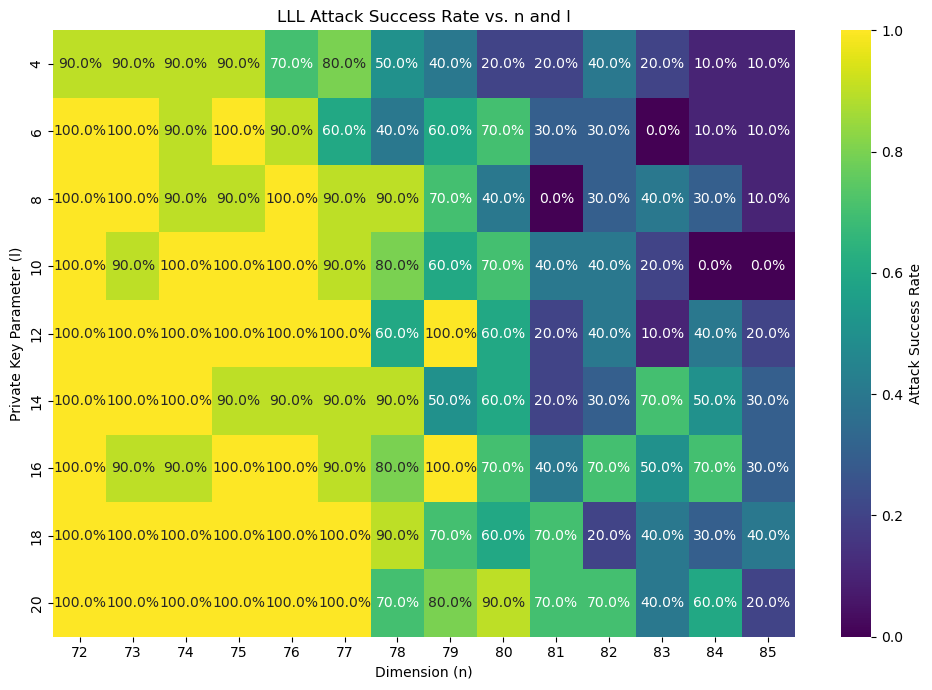

In [150]:
# --- Experiment Parameters ---
# WARNING: n=70 is where you saw failure. This will take a long time.
# Start with smaller values (e.g., n_range = range(10, 31, 10)) to see it work.

# Example: Fast test
# n_values = range(10, 31, 10)  # n = 10, 20, 30
# l_values = range(2, 7, 2)   # l = 2, 4, 6
# trials_per_pair = 5

# Example: Full experiment (will be slow)
n_values = range(72, 86, 1)  # n = 50, 60, 70, 80
l_values = range(4, 21, 2)   # l = 2, 4, 6, 8, 10
trials_per_pair = 10


results_df = run_2d_experiment(n_values, l_values, trials_per_pair)

# --- Save and Display Results ---
if pd is not None:
    # Save the raw data
    csv_filename = 'ggh_n_vs_l_results.csv'
    try:
        results_df.to_csv(csv_filename, index=False)
        print(f"Full results saved to {csv_filename}")
    except Exception as e:
        print(f"Error saving results: {e}")

    # Create the pivot table (summary) for the heatmap
    # This calculates the *mean success rate* for each (n, l) pair
    pivot = results_df.pivot_table(index='l', columns='n', 
                                     values='attack_succeeded', aggfunc='mean')
    
    print("\n--- Success Rate Pivot Table (l vs n) ---")
    print(pivot)

    # --- Plot the Heatmap ---
    print("\nGenerating heatmap...")
    try:
        import matplotlib.pyplot as plt
        import seaborn as sns
        
        plt.figure(figsize=(10, 7))
        sns.heatmap(pivot, annot=True, fmt=".1%", cmap="viridis", 
                    cbar_kws={'label': 'Attack Success Rate'})
        plt.title('LLL Attack Success Rate vs. n and l')
        plt.xlabel('Dimension (n)')
        plt.ylabel('Private Key Parameter (l)')
        plt.tight_layout()
        
        # Save the plot to a file
        plot_filename = 'ggh_attack_heatmap.png'
        plt.savefig(plot_filename)
        print(f"Heatmap saved to {plot_filename}")
        
        # Show the plot inline in the notebook
        plt.show()
        
    except ImportError:
        print("Install matplotlib and seaborn to plot the heatmap.")
else:
    print(results_df[0:5])
